In [1]:
import qutip as qp
from qutip import basis, ket2dm, sigmay, sigmax, tensor, destroy, qeye, tracedist
import numpy as np
import matplotlib.pyplot as plt
x_coupling=0
epsilon=.1
tlist = np.linspace(0, 2*np.pi/epsilon, 2000)

In [2]:
def measure(states, operators):
    is_dm = (states[0].isoper)
    if not is_dm:
        for i, s in enumerate(states):
            states[i]=ket2dm(states[i])
    measurements = []
    for op in operators:
        measurements.append([(s*op).tr() for s in states])
    return measurements

In [3]:
def coupling(t,args):
    return x_coupling
def drive_a(t, args):
    return np.exp(1j*(epsilon*t))
def drive_b(t,args):
    return np.conj(drive_a(t,args))

In [4]:
eta=.5
omega_rabi=epsilon/(4*eta)
N=15
a = tensor(qeye(2),qeye(2),destroy(N))
sigma_a = tensor(sigmay(), qeye(2),qeye(N))
sigma_b = tensor(qeye(2),sigmay(), qeye(N))
Ha = -eta*omega_rabi*a.dag() * (sigma_a+sigma_b)
Hb = -eta*omega_rabi*a * (sigma_a+sigma_b)

sigma_1 = tensor(sigmax(), qeye(2),qeye(N))
sigma_2 = tensor(qeye(2),sigmax(), qeye(N))
H1 = -eta*omega_rabi*a.dag() * (sigma_1+sigma_2)
H2 = -eta*omega_rabi*a * (sigma_1+sigma_2)

H=[[Ha,drive_a],[Hb, drive_b],[H1+H2,coupling]]

atom_states={'ground': basis(2,0), 'first-excited': basis(2,1), 'x': (basis(2,0)+basis(2,1)).unit(), \
    'y':(basis(2,0)+1j*basis(2,1)).unit()}
state1 = 'first-excited'
state2 = 'first-excited' #Expected output |ee> + i |gg>
expected = (\
    1j*tensor(basis(2,0),basis(2,0))-tensor(basis(2,1),basis(2,1))\
        )/np.sqrt(2)
psi0 = tensor(atom_states[state1], atom_states[state2],basis(N,5))

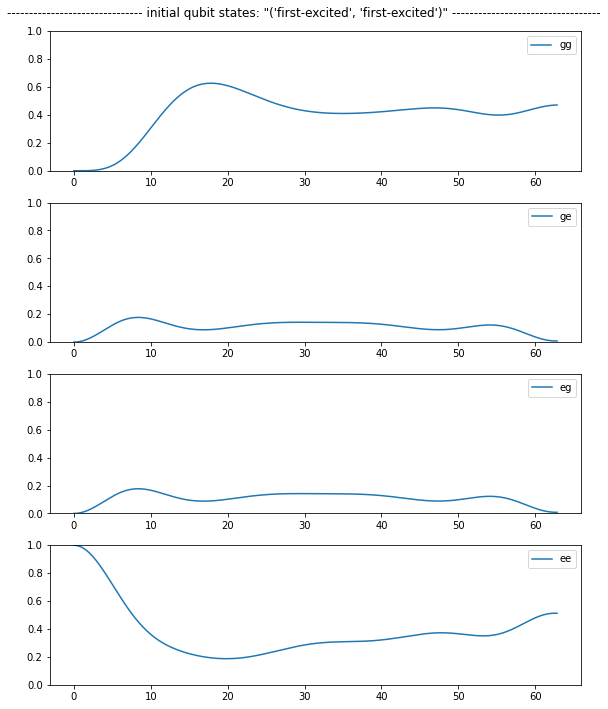

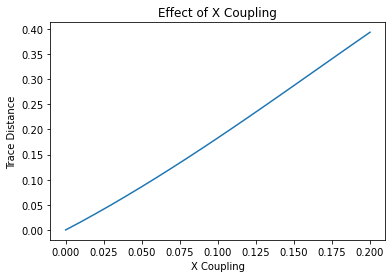

In [5]:
def run(x_coupling, show=False):
    # solve
    states = qp.sesolve(H,psi0,tlist).states
    if show:
        two_pl_states = [s.ptrace([0,1]) for s in states]
        m_ge = tensor(ket2dm(basis(2,0)),ket2dm(basis(2,1)), qeye(N))
        m_gg = tensor(ket2dm(basis(2,0)),ket2dm(basis(2,0)), qeye(N))
        m_ee = tensor(ket2dm(basis(2,1)),ket2dm(basis(2,1)), qeye(N))
        m_eg = tensor(ket2dm(basis(2,1)),ket2dm(basis(2,0)), qeye(N))
        ge, gg, ee, eg = measure(states,[m_ge, m_gg, m_ee, m_eg])
        fig, ax = plt.subplots(4,1 ,figsize=(8,10), tight_layout=True, edgecolor='black')
        fig.suptitle(f'------------------------------- initial qubit states: "{state1, state2}" ----------------------------------')
        ax[0].plot(tlist, gg)
        ax[0].legend(['gg'])
        ax[0].set_ylim(0,1)
        ax[1].plot(tlist, ge)
        ax[1].set_ylim(0,1)
        ax[1].legend(['ge'])
        ax[2].plot(tlist, eg)
        ax[2].set_ylim(0,1)
        ax[2].legend(['eg'])
        ax[3].plot(tlist, ee)
        ax[3].legend(['ee'])
        ax[3].set_ylim(0,1)
        plt.show()
    return tracedist(states[-1].ptrace([0,1]),expected)
x_couplings = np.linspace(0,.2,21)
dists=[]
for x_coupling in x_couplings:
    error = run(x_coupling,x_coupling==.14)
    dists.append(error)
plt.plot(x_couplings,dists)
plt.title('Effect of X Coupling')
plt.ylabel("Trace Distance")
plt.xlabel('X Coupling')
plt.show()    